In [3]:
# pip install torchaudio

In [52]:
import torch
import torchaudio
import librosa

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [55]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILE = './output/MR.wav'

In [56]:
SPEECH_FILE

'./output/MR.wav'

In [57]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [58]:
IPython.display.Audio(SPEECH_FILE)

In [59]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)

In [60]:
waveform.shape

torch.Size([2, 322560])

In [61]:
sample_rate

44100

In [62]:
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

waveform

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0025, 0.0021, 0.0017],
        [0.0000, 0.0000, 0.0000,  ..., 0.0025, 0.0021, 0.0017]])

In [63]:
# plt.figure(figsize=(30, 16))
# # plt.subplot(2, 1, 1)
# plt.plot(waveform.t().numpy())
# plt.title('Waveform')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

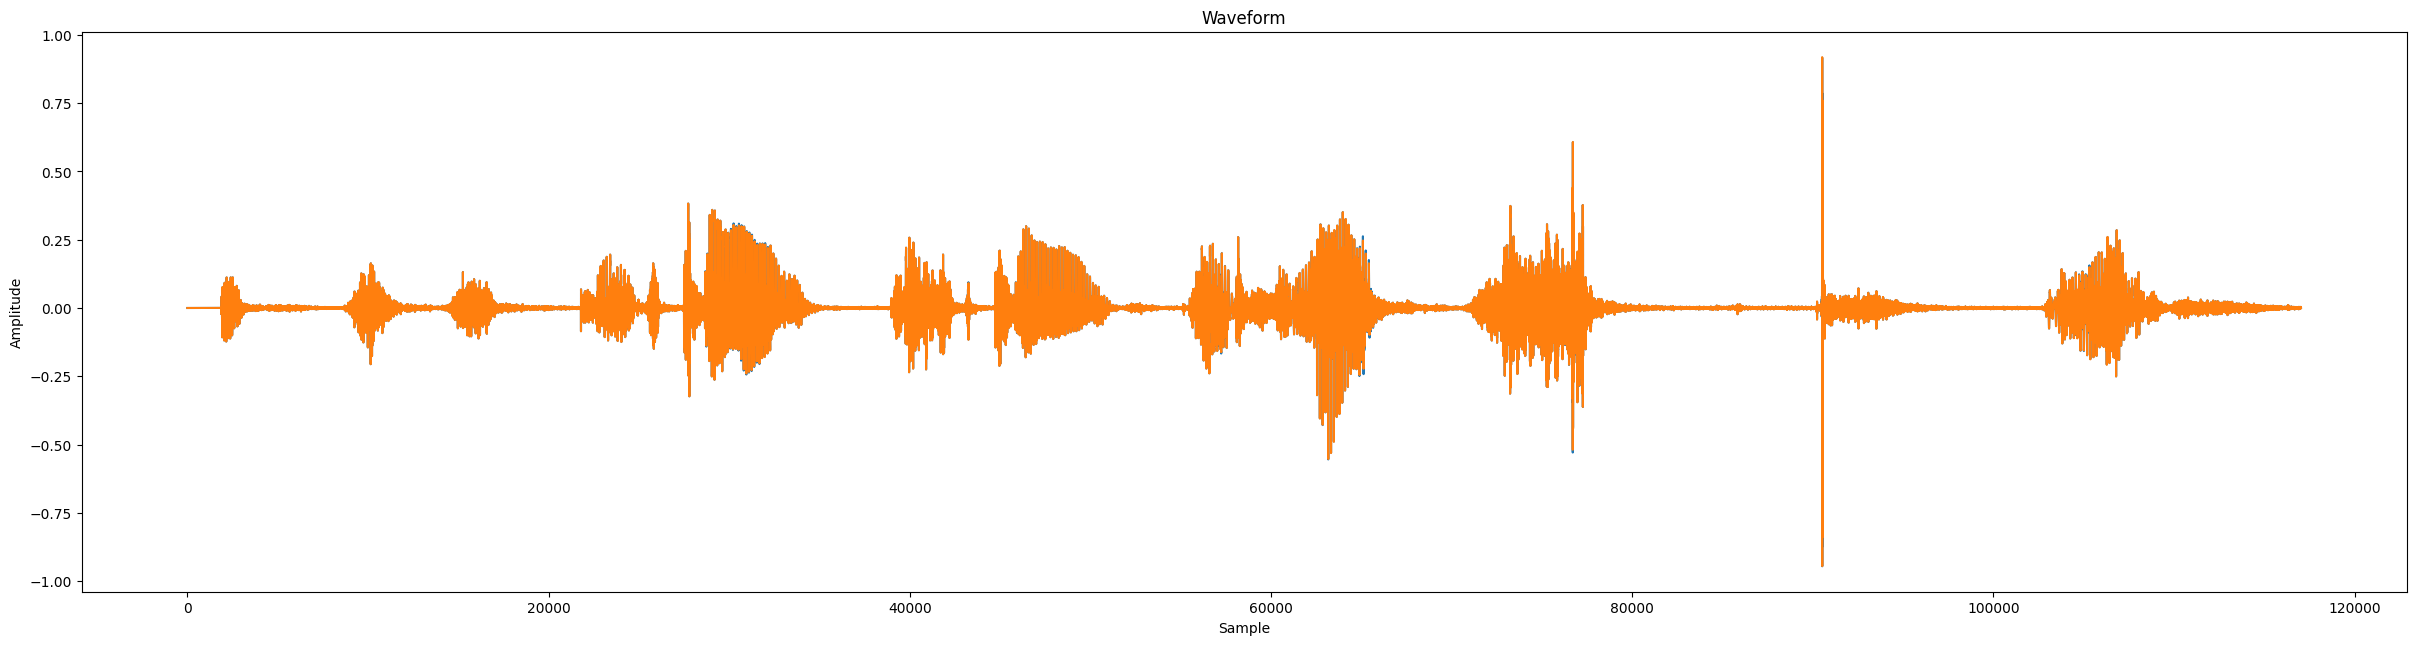

In [64]:
plt.figure(figsize=(30, 16))
plt.subplot(2, 1, 1)
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

In [65]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
features[:3]

[tensor([[[-0.0382,  0.4876,  0.2697,  ...,  0.5417,  0.1702,  0.1327],
          [-0.0245,  0.5300,  0.1798,  ...,  0.5806,  0.1455,  0.1496],
          [-0.0172,  0.4843,  0.1402,  ...,  0.5246,  0.1600,  0.1777],
          ...,
          [ 0.2116,  0.0269,  0.2839,  ...,  0.2541,  0.2574,  0.2720],
          [ 0.4624,  0.2607,  0.2538,  ..., -0.1875,  0.1501,  0.1666],
          [ 0.3382,  0.0888,  0.1508,  ..., -0.1698,  0.1610,  0.0772]],
 
         [[-0.0343,  0.4866,  0.2710,  ...,  0.5411,  0.1693,  0.1326],
          [-0.0220,  0.5285,  0.1816,  ...,  0.5820,  0.1440,  0.1500],
          [-0.0156,  0.4827,  0.1425,  ...,  0.5262,  0.1577,  0.1789],
          ...,
          [ 0.2093,  0.0242,  0.2839,  ...,  0.2553,  0.2576,  0.2712],
          [ 0.4602,  0.2579,  0.2541,  ..., -0.1870,  0.1481,  0.1662],
          [ 0.3383,  0.0889,  0.1524,  ..., -0.1703,  0.1608,  0.0777]]]),
 tensor([[[ 2.3509e-01, -8.3950e-02,  1.8336e-01,  ...,  6.7060e-01,
           -1.6788e-02,  2.1894

In [66]:
len(features)

12

In [67]:
features[1].shape

torch.Size([2, 365, 768])

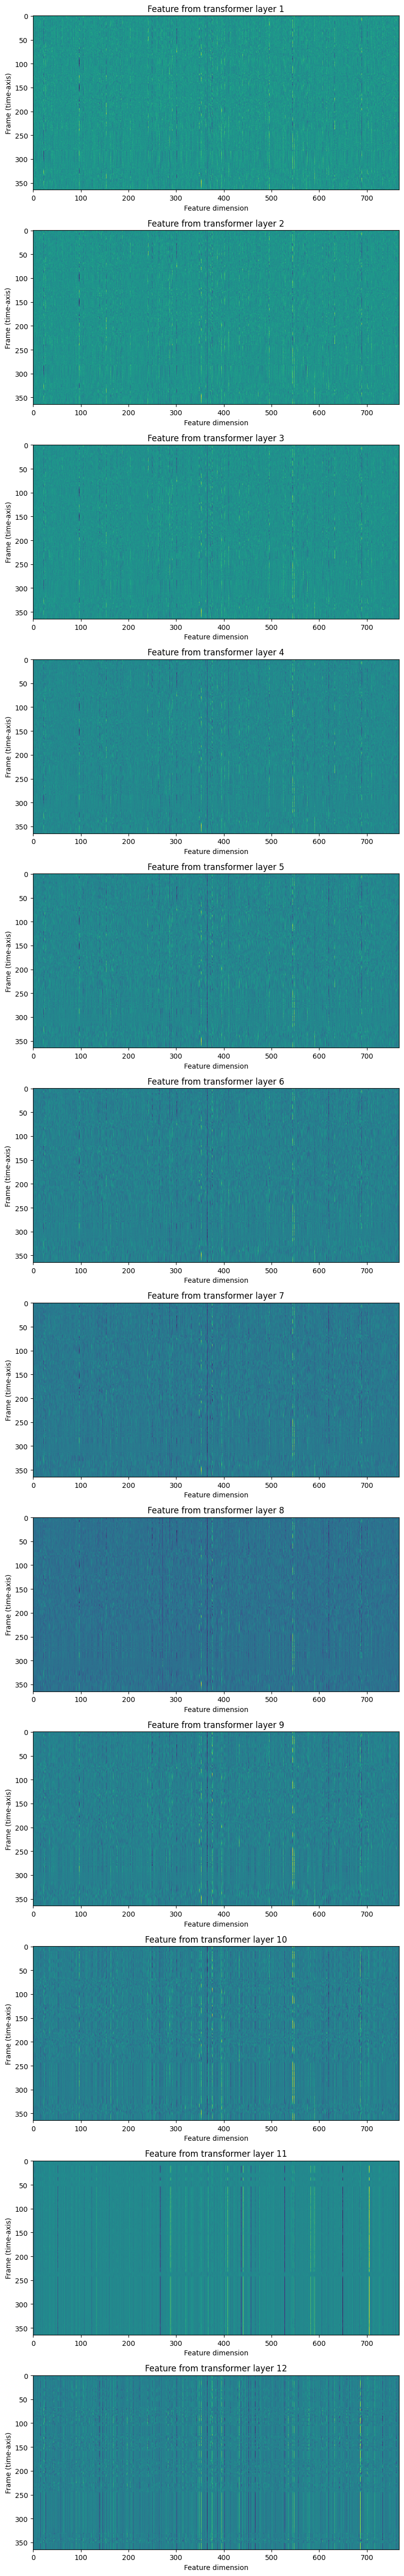

In [68]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [69]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


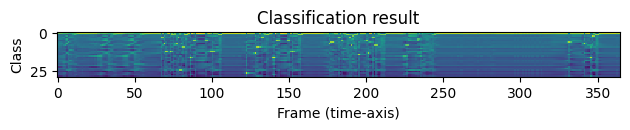

In [70]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [71]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices]).replace('|', ' ')

In [72]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
transcript

"TILL IT'S COOL JUST COOL INTO THE MOUTH HAW NICE "

In [73]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)


TILL IT'S COOL JUST COOL INTO THE MOUTH HAW NICE 
